In [26]:

import cv2
import numpy as np
from matplotlib import pyplot as plt
import win32gui, win32ui, win32con, win32api

def grab_screen(region=None):

    hwin = win32gui.GetDesktopWindow()

    if region:
            left,top,x2,y2 = region
            width = x2 - left + 1
            height = y2 - top + 1
    else:
        width = win32api.GetSystemMetrics(win32con.SM_CXVIRTUALSCREEN)
        height = win32api.GetSystemMetrics(win32con.SM_CYVIRTUALSCREEN)
        left = win32api.GetSystemMetrics(win32con.SM_XVIRTUALSCREEN)
        top = win32api.GetSystemMetrics(win32con.SM_YVIRTUALSCREEN)

    hwindc = win32gui.GetWindowDC(hwin)
    srcdc = win32ui.CreateDCFromHandle(hwindc)
    memdc = srcdc.CreateCompatibleDC()
    bmp = win32ui.CreateBitmap()
    bmp.CreateCompatibleBitmap(srcdc, width, height)
    memdc.SelectObject(bmp)
    memdc.BitBlt((0, 0), (width, height), srcdc, (left, top), win32con.SRCCOPY)
    
    signedIntsArray = bmp.GetBitmapBits(True)
    img = np.fromstring(signedIntsArray, dtype='uint8')
    img.shape = (height,width,4)

    srcdc.DeleteDC()
    memdc.DeleteDC()
    win32gui.ReleaseDC(hwin, hwindc)
    win32gui.DeleteObject(bmp.GetHandle())

    return cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

In [23]:
import ctypes
import time

SendInput = ctypes.windll.user32.SendInput


W = 0x11
A = 0x1E
S = 0x1F
D = 0x20
E = 0x12
SPACE = 0x39

NP_2 = 0x50
NP_4 = 0x4B
NP_6 = 0x4D
NP_8 = 0x48

# C struct redefinitions 
PUL = ctypes.POINTER(ctypes.c_ulong)
class KeyBdInput(ctypes.Structure):
    _fields_ = [("wVk", ctypes.c_ushort),
                ("wScan", ctypes.c_ushort),
                ("dwFlags", ctypes.c_ulong),
                ("time", ctypes.c_ulong),
                ("dwExtraInfo", PUL)]

class HardwareInput(ctypes.Structure):
    _fields_ = [("uMsg", ctypes.c_ulong),
                ("wParamL", ctypes.c_short),
                ("wParamH", ctypes.c_ushort)]

class MouseInput(ctypes.Structure):
    _fields_ = [("dx", ctypes.c_long),
                ("dy", ctypes.c_long),
                ("mouseData", ctypes.c_ulong),
                ("dwFlags", ctypes.c_ulong),
                ("time",ctypes.c_ulong),
                ("dwExtraInfo", PUL)]

class Input_I(ctypes.Union):
    _fields_ = [("ki", KeyBdInput),
                 ("mi", MouseInput),
                 ("hi", HardwareInput)]

class Input(ctypes.Structure):
    _fields_ = [("type", ctypes.c_ulong),
                ("ii", Input_I)]

# Actuals Functions

def PressKey(hexKeyCode):
    extra = ctypes.c_ulong(0)
    ii_ = Input_I()
    ii_.ki = KeyBdInput( 0, hexKeyCode, 0x0008, 0, ctypes.pointer(extra) )
    x = Input( ctypes.c_ulong(1), ii_ )
    ctypes.windll.user32.SendInput(1, ctypes.pointer(x), ctypes.sizeof(x))

def ReleaseKey(hexKeyCode):
    extra = ctypes.c_ulong(0)
    ii_ = Input_I()
    ii_.ki = KeyBdInput( 0, hexKeyCode, 0x0008 | 0x0002, 0, ctypes.pointer(extra) )
    x = Input( ctypes.c_ulong(1), ii_ )
    ctypes.windll.user32.SendInput(1, ctypes.pointer(x), ctypes.sizeof(x))

C:\Users\Simon\AppData\Local\Temp\ipykernel_14924\2594829235.py:29: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img = np.fromstring(signedIntsArray, dtype='uint8')


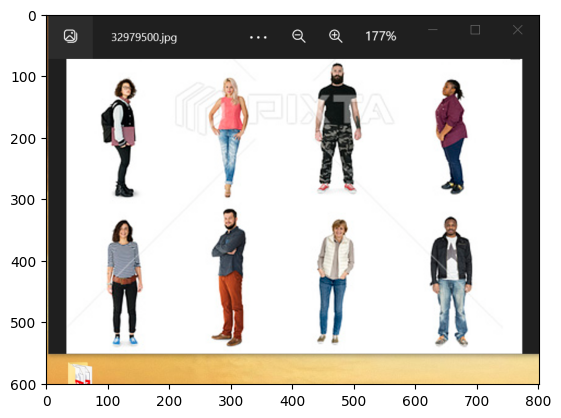

In [2]:
screenImg = grab_screen(region=(0,0,800,600))

plt.imshow(screenImg)

In [34]:
# import the necessary packages
#import numpy as np
#import cv2
 
# initialize the HOG descriptor/person detector
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

cv2.startWindowThread()

# open webcam video stream
#cap = cv2.VideoCapture(0)

# the output will be written to output.avi
out = cv2.VideoWriter(
    'output.avi',
    cv2.VideoWriter_fourcc(*'MJPG'),
    15.,
    (640,480))

pX = (1280-400)//2
pY = (1024-300)//2
sizeX = 400
sizeY = 300

while(True):
    # Capture frame-by-frame
    frame = grab_screen(region=(pX,pY,pX+sizeX,pY+sizeY))
    #frame = grab_screen(region=(3840/2,1080/2,800,600))

    # resizing for faster detection
    frame = cv2.resize(frame, (640, 480))
    # using a greyscale picture, also for faster detection
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # detect people in the image
    # returns the bounding boxes for the detected objects
    boxes, weights = hog.detectMultiScale(frame, winStride=(8,8) )

    boxes = np.array([[x, y, x + w, y + h] for (x, y, w, h) in boxes])

    needToBreak = False

    for (xA, yA, xB, yB) in boxes:
        # display the detected boxes in the colour picture
        if (yB - yA) < 220:
            cv2.rectangle(frame, (xA, yA), (xB, yB), (0, 255, 0), 2)
        else:
            cv2.rectangle(frame, (xA, yA), (xB, yB), (255, 0, 0), 2)
            needToBreak = True
       # print("size: x {} - y {}".format((xB - xA), (yB - yA)))
    
    if needToBreak:
        #PressKey(32)
        PressKey(SPACE)
        ReleaseKey(W)
    else:
        ReleaseKey(SPACE)

    # Write the output video 
    out.write(frame.astype('uint8'))
    # Display the resulting frame
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
#cap.release()
# and release the output
out.release()
# finally, close the window
cv2.destroyAllWindows()
cv2.waitKey(1)

TypeError: integer argument expected, got float